In [1]:
import pdfplumber
from voyageai import Client
import pinecone
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from dotenv import load_dotenv
import os

f:\FILE EROS\Portofolio 01\Embeddings\embeddings\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Muat variabel lingkungan dari file .env
load_dotenv()

True

In [3]:
# Fungsi untuk membagi teks menjadi potongan kecil (chunking) dengan overlap
def chunk_text_with_overlap(text, chunk_size=800, overlap=100):
    if overlap >= chunk_size:
        raise ValueError("Overlap harus lebih kecil dari chunk_size")

    chunks = []
    start = 0
    text_length = len(text)

    while start < text_length:
        end = min(start + chunk_size, text_length) 
        chunks.append(text[start:end])
        start += chunk_size - overlap 

    return chunks

In [4]:
# Fungsi untuk membagi data ke dalam batch
def batchify(data, batch_size=128):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

In [5]:
# Ekstraksi teks PDF
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text_data = [page.extract_text() for page in pdf.pages]
    return text_data

In [6]:
pdf_path = "Datasheet.pdf"
text_data = extract_text_from_pdf(pdf_path)
print(f"Teks berhasil diekstrak dari PDF: {len(text_data)} halaman")

Teks berhasil diekstrak dari PDF: 100 halaman


In [7]:
# Membuat chunk dari semua teks dengan chunk size 800 dan overlap 100
chunk_size = 800
overlap = 100
chunks = []
for page_text in text_data:
    if page_text:
        chunks.extend(chunk_text_with_overlap(page_text, chunk_size, overlap))
print(f"Teks berhasil dibagi menjadi {len(chunks)} chunk")

Teks berhasil dibagi menjadi 299 chunk


In [8]:
# Inisialisasi Voyage AI untuk embedding
voyage_client = Client(api_key=os.getenv("VOYAGE_API_KEY"))

In [9]:
# Membuat embedding dengan pembagian batch
batch_size = 128
all_embeddings = []

for batch in batchify(chunks, batch_size):
    response = voyage_client.embed(
        texts=batch,
        model="voyage-3"
    ).embeddings
    all_embeddings.extend(response)
print(f"Embedding berhasil dibuat untuk {len(all_embeddings)} chunk")

Embedding berhasil dibuat untuk 299 chunk


In [10]:
# Inisialisasi Pinecone
pinecone_instance = pinecone.Pinecone(api_key=os.getenv("PINECONE_API_KEY"), environment=os.getenv("PINECONE_ENVIRONMENT"))

In [11]:
index_name = "your-index-name"
index = pinecone_instance.Index(index_name, host="https://your-pinecone-host.svc.aped-4627-b74a.pinecone.io")

In [12]:
namespace = "your-namespace"

In [13]:
# Unggah embedding ke Pinecone dengan namespace
data = [
    {"id": f"chunk-{i}", "values": all_embeddings[i], "metadata": {"text": chunks[i]}}
    for i in range(len(chunks))
]
index.upsert(vectors=data, namespace=namespace)
print(f"Dataset dengan {len(data)} chunk telah berhasil diunggah ke Pinecone dengan namespace '{namespace}'.")

Dataset dengan 299 chunk telah berhasil diunggah ke Pinecone dengan namespace 'pencatatan-sipil-3'.


In [27]:
# Memeriksa statistik indeks
stats = index.describe_index_stats(namespace="your-namespace")
print(f"Statistik Indeks untuk namespace '{namespace}': {stats}")

Statistik Indeks untuk namespace 'pencatatan-sipil-3': {'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'pencatatan-sipil': {'vector_count': 280},
                'pencatatan-sipil-2': {'vector_count': 280},
                'pencatatan-sipil-3': {'vector_count': 299}},
 'total_vector_count': 859}


In [28]:
# Memilih satu embedding dari dataset
test_embedding = all_embeddings[0]  # Contoh dari embedding pertama

In [29]:
# Melakukan query ke Pinecone
query_result = index.query(vector=test_embedding, top_k=10, namespace=namespace, include_metadata=True)

In [30]:
# Menampilkan hasil query
print("Hasil Query untuk Embedding Pertama:")
if query_result and "matches" in query_result:
    for match in query_result["matches"]:
        print(f"ID: {match['id']}, Skor: {match['score']}, Metadata: {match['metadata']}")
else:
    print("Tidak ada hasil yang ditemukan untuk query tersebut.")

Hasil Query untuk Embedding Pertama:
ID: chunk-0, Skor: 1.00000012, Metadata: {'text': 'Berikut adalah versi yang diperluas dan lebih informatif:\nKenalan dengan DISMAKA – Chatbot Pintar Disdukcapil Semarang!\nDISMAKA merupakan singkatan dari Disdukcapil Semarang Cakap, sebuah chatbot berbasis\nWhatsApp yang dirancang untuk membantu masyarakat Kota Semarang dalam memperoleh\ninformasi terkait administrasi kependudukan dengan cepat, mudah, dan efisien.\nMenggabungkan teknologi AI mutakhir dengan sistem berbasis GPT-4o Mini, DISMAKA\nhadir sebagai solusi inovatif untuk menjawab kebutuhan layanan informasi publik kapan saja dan\ndi mana saja. Dengan operasional 24/7, chatbot ini siap memberikan panduan prosedur yang\njelas, menjawab pertanyaan umum, dan membantu masyarakat mengakses informasi\nakurat tanpa harus datang langsung ke kantor Disdukcapil.\nDISMAKA Diciptakan oleh Talenta Muda '}
ID: chunk-3, Skor: 0.72932744, Metadata: {'text': '4. Akses Mudah melalui WhatsApp\nCukup kirim pes

In [31]:
# Query teks untuk diuji
query_text = "bagaiamana cara mengubah ktp jika saya sudah menetap di jakarta, apakah saya perlu ke kantor disdukcapil kota semarang dulu ?"

In [32]:
# Buat embedding untuk query teks
query_embedding = voyage_client.embed(texts=[query_text], model="voyage-3").embeddings[0]
print(f"Embedding untuk query: {query_embedding}")

Embedding untuk query: [-0.04813623055815697, 0.017254307866096497, 0.043780576437711716, -0.027008626610040665, 0.03613678365945816, -0.018671678379178047, -0.0045041367411613464, 0.033458027988672256, 0.01206985954195261, 0.012035692110657692, 0.003642141819000244, 0.027459049597382545, 0.013449348509311676, -0.02074689045548439, -0.007945356890559196, 0.04135376960039139, 0.01289152167737484, 0.014670477248728275, -0.029663914814591408, 0.009659319184720516, -0.0062592485919594765, -0.015859071165323257, -0.02686913311481476, -0.02073812671005726, 0.031803712248802185, 0.05671146512031555, -0.015473495237529278, -0.005323347635567188, 0.0015341354301199317, -0.005203611683100462, -0.022251872345805168, -0.006709075532853603, -0.0038315504789352417, -0.021234264597296715, 0.04023900628089905, -0.014750399626791477, -0.02218264527618885, -0.015247169882059097, 0.01957996003329754, -0.015945902094244957, -0.00671447953209281, 2.7334262995282188e-05, -0.014627098105847836, 0.05279092863

In [33]:
# Melakukan pencarian di Pinecone
query_result = index.query(vector=query_embedding, top_k=10, namespace=namespace, include_metadata=True)

In [34]:
# Menampilkan hasil pencarian
print("Hasil Query Berdasarkan Teks:")
if query_result and "matches" in query_result:
    for match in query_result["matches"]:
        print(f"ID: {match['id']}, Skor: {match['score']}, Metadata: {match['metadata']}")
else:
    print("Tidak ada hasil yang ditemukan untuk query tersebut.")

Hasil Query Berdasarkan Teks:
ID: chunk-108, Skor: 0.740073383, Metadata: {'text': "kantor disdukcapil di jl. kanguru raya no. 3 semarang.\n• pengajuan pembuatan ktp hanya dapat dilakukan secara langsung di kantor.\n• pengurusan ktp hilang tidak tersedia di aplikasi si d'nok dan harus diajukan langsung di\nkantor.\n• perbaruan ktp rusak juga hanya bisa dilakukan langsung di kantor.\n• jika kk sudah dibuat di semarang tetapi data masih tercatat di jakarta, informasi lebih lanjut\ndapat diperoleh dengan menghubungi wa 089676309299, twitter (@dukcapilkotasmg),\natau instagram (@disdukcapilkotasemarang).\n• pengajuan ktp hilang tidak tersedia secara online dan harus dilakukan langsung di kantor.\n• untuk memperbarui alamat ktp dan kk: ajukan permohonan perpindahan keluar dan\nkedatangan melalui aplikasi si d'nok.\n• pengajuan cetak ktp hilang memerlukan fc kk dan surat kehilangan asli d"}
ID: chunk-85, Skor: 0.728802323, Metadata: {'text': '• pembuatan ktp baru untuk warga dengan domisili 

In [35]:
# Query Pencarian Semantik
def semantic_search(query_text):
    # Buat embedding untuk query
    query_embedding = voyage_client.embed(
        texts=[query_text],
        model="voyage-3"
    ).embeddings[0]

    # Cari dalam Pinecone
    results = index.query(vector=query_embedding, top_k=10, namespace=namespace, include_metadata=True)
    return results

In [36]:
# Contoh query
query = "Apa itu Dismaka ? siapa yang membuatnya ?"
results = semantic_search(query)


In [37]:
# Cetak hasil
print("Hasil Query dari Semantic Search:")
if results and "matches" in results:
    for match in results["matches"]:
        print(f"ID: {match['id']}, Skor: {match['score']}, Metadata: {match['metadata']}")
else:
    print("Tidak ada hasil yang ditemukan untuk query tersebut.")


Hasil Query dari Semantic Search:
ID: chunk-1, Skor: 0.383264095, Metadata: {'text': 'masi\nakurat tanpa harus datang langsung ke kantor Disdukcapil.\nDISMAKA Diciptakan oleh Talenta Muda Berprestasi\nChatbot ini dikembangkan oleh Eros Alfedo Hermanto, seorang mahasiswa semester akhir dari\nUIN Walisongo Semarang yang memiliki dedikasi tinggi untuk menciptakan solusi digital\nberbasis kecerdasan buatan (AI). Dengan ketekunan dan kreativitasnya, Eros menghadirkan\nDISMAKA sebagai wujud kontribusi nyata dalam mendukung transformasi digital di\nlingkungan pemerintahan.\nFitur Utama DISMAKA\n1. Panduan Prosedur Layanan Kependudukan\nMemberikan informasi langkah-langkah dalam pengurusan dokumen seperti:\no Kartu Tanda Penduduk (KTP)\no Kartu Keluarga (KK)\no Akta Kelahiran dan Akta Kematian\no Surat Pindah Domisili\no Perubahan Data Kependudukan\n2. Menjawab Pertanyaan Umum ❓\nChatbot ini siap m'}
ID: chunk-0, Skor: 0.35428828, Metadata: {'text': 'Berikut adalah versi yang diperluas dan leb

In [38]:
# Visualisasi Data dengan t-SNE
def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5)
    for i, label in enumerate(labels):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label, fontsize=9)
    plt.title("Visualisasi Embedding dengan t-SNE")
    plt.show()

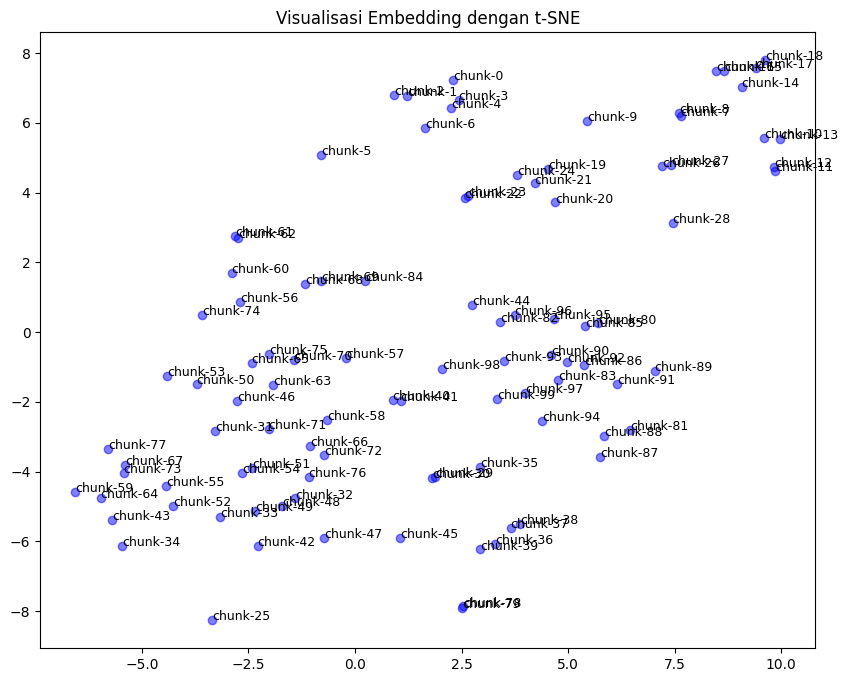

In [39]:
# Contoh visualisasi untuk 100 chunk pertama
visualize_embeddings(all_embeddings[:100], [f"chunk-{i}" for i in range(100)])